In [11]:
print(np_data[:200,:])
print(np_data[:200,[0,1,3,5,6,7,10,11,12,13,14,17,18,19,22,23,24]].shape)
np_data[:200,[5,7,10,14,17,19,22,24]])
np_data[:200,[4,10,17]])

[[36.9  21.8   1.7  ...  2.    0.32  2.4 ]
 [36.1  12.9   2.8  ...  2.    0.32  1.8 ]
 [25.3  13.7   1.8  ...  2.    0.32  1.3 ]
 ...
 [20.7  14.5   1.4  ...  4.    2.89  3.9 ]
 [35.2  12.7   2.8  ...  4.    2.89  3.8 ]
 [42.1  17.    2.5  ...  4.    2.89  4.4 ]]
(200, 17)


In [7]:
import sys
sys.path.append("/root/autodl-tmp/pykan-master")
from kan import *
import torch
from kan import KAN, create_dataset
import pandas as pd
import numpy as np

def split_validation_column(train_input, column_idx, val_ratio=0.2):
    """
    从训练数据中分离出指定列作为验证集
    
    参数:
    train_input (torch.Tensor): 输入的训练数据张量
    column_idx (int): 要选择作为验证集的列索引
    val_ratio (float): 验证集占原始数据的比例，默认为0.2
    
    返回:
    train_data (torch.Tensor): 剩余的训练数据
    val_data (torch.Tensor): 选出的验证数据
    """
    
    # 获取数据总长度
    total_size = train_input.shape[0]
    
    # 计算验证集大小
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size
    
    # 随机打乱索引
    indices = torch.randperm(total_size)
    
    # 分割索引
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]
    
    # 分离出指定列
    train_out = train_input[train_indices, column_idx].unsqueeze(1)  # 添加维度保持2D形状
    val_out = train_input[val_indices, column_idx].unsqueeze(1)  # 添加维度保持2D形状
    # 创建新的训练数据，去掉验证集的那一列
    train_data = torch.cat((train_input[:, :column_idx], 
                           train_input[:, column_idx+1:]), dim=1)
    train_in = train_data[train_indices]
    val_in = train_data[val_indices]
    
    return train_in, val_in, train_out, val_out



# Device setup: Use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the KAN model and move it to the GPU
model = KAN(width=[14, 20, 10, 1], grid=10, k=3, seed=1).to(device)

# Define a sample function and create a dataset (for demonstration)
f = lambda x: torch.exp((torch.sin(torch.pi * (x[:, [0]]**2 + x[:, [1]]**2)) + torch.sin(torch.pi * (x[:, [2]]**2 + x[:, [3]]**2))) / 2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# Load and process the CSV data
df = pd.read_csv('Airline_Delay_Cause.csv')

# # Process timestamp: Convert to Unix timestamp (seconds since 1970)
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
# df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp()).astype('float64')

# # Process risk_classification: Map categories to numerical values
# risk_map = {'Low Risk': 0.0, 'Moderate Risk': 0.5, 'High Risk': 1.0}
# df['risk_classification'] = df['risk_classification'].map(risk_map).astype('float64')

# Convert DataFrame to NumPy array with float32 type

df = df.iloc[:, 6:]
# print(df)
structured_array = df.to_numpy().astype(np.float32)

# Standardization function: Normalize along dimension 0
def normalize_along_dim0(tensor):
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0, unbiased=True)
    normalized_tensor = (tensor - mean) / (std + 1e-8)  # Add small constant to avoid division by zero
    return normalized_tensor

# Split data into train and test sets and move to GPU

# structured_array = np.nan_to_num(structured_array, nan=0.0, posinf=0.0, neginf=0.0)
train_input = torch.from_numpy(structured_array[:30000, :]).float().to(device)
print(train_input[:10])
print(train_input.shape)  # 确认张量形状
print(torch.isnan(train_input).any())  # 检查是否有 NaN
print(torch.isinf(train_input).any())  # 检查是否有 Inf
mask = ~torch.isnan(train_input).any(dim=1)
train_input = train_input[mask]
train_input = normalize_along_dim0(train_input)
# print(train_input[:10])
train_input, test_input, train_label, test_label = split_validation_column(train_input, 9)

# print(train_input[:10])
# print(train_label[:10])

# col_to_remove = 2
# train_input = torch.cat((train_input[:, :col_to_remove], train_input[:, col_to_remove + 1:]), dim=1)
# test_input = torch.cat((test_input[:, :col_to_remove], test_input[:, col_to_remove + 1:]), dim=1)
# train_label = torch.from_numpy(structured_array[:10000, 2+1:2+2]).float().to(device)
# test_label = torch.from_numpy(structured_array[29000:, 2+1:2+2]).float().to(device)

# Normalize the data
# train_input = normalize_along_dim0(train_input)
# test_input = normalize_along_dim0(test_input)
# train_label = normalize_along_dim0(train_label)
# test_label = normalize_along_dim0(test_label)

# Update dataset with processed data
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

# Print shapes to verify
print(dataset['train_input'].shape, dataset['test_input'].shape, dataset['train_label'].shape, dataset['test_label'].shape)

# Train the model on GPU
model.fit(dataset, opt="LBFGS", steps=20)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0
tensor([[8.9000e+01, 1.3000e+01, 2.2500e+00, 1.6000e+00, 3.1600e+00, 0.0000e+00,
         5.9900e+00, 2.0000e+00, 1.0000e+00, 1.3750e+03, 7.1000e+01, 7.6100e+02,
         1.1800e+02, 0.0000e+00, 4.2500e+02],
        [6.2000e+01, 1.0000e+01, 1.9700e+00, 4.0000e-02, 5.7000e-01, 0.0000e+00,
         7.4200e+00, 0.0000e+00, 1.0000e+00, 7.9900e+02, 2.1800e+02, 1.0000e+00,
         6.2000e+01, 0.0000e+00, 5.1800e+02],
        [6.2000e+01, 1.0000e+01, 2.7300e+00, 1.1800e+00, 1.8000e+00, 0.0000e+00,
         4.2800e+00, 1.0000e+00, 0.0000e+00, 7.6600e+02, 5.6000e+01, 1.8800e+02,
         7.8000e+01, 0.0000e+00, 4.4400e+02],
        [6.6000e+01, 1.2000e+01, 3.6900e+00, 2.2700e+00, 4.4700e+00, 0.0000e+00,
         1.5700e+00, 1.0000e+00, 1.0000e+00, 1.3970e+03, 4.7100e+02, 3.2000e+02,
         3.8800e+02, 0.0000e+00, 2.1800e+02],
        [9.2000e+01, 2.2000e+01, 7.7600e+00, 0.0000e+00, 2.9600e+00, 0.0000e+00,
     

| train_loss: 4.61e-03 | test_loss: 4.15e-02 | reg: 6.88e+01 | : 100%|█| 20/20 [00:11<00:00,  1.72it

saving model version 0.1


{'train_loss': [array(0.1558811, dtype=float32),
  array(0.03955888, dtype=float32),
  array(0.02415301, dtype=float32),
  array(0.01731918, dtype=float32),
  array(0.01321877, dtype=float32),
  array(0.01074121, dtype=float32),
  array(0.00922901, dtype=float32),
  array(0.00798916, dtype=float32),
  array(0.00729885, dtype=float32),
  array(0.00674953, dtype=float32),
  array(0.00648418, dtype=float32),
  array(0.00597091, dtype=float32),
  array(0.00562548, dtype=float32),
  array(0.00533295, dtype=float32),
  array(0.00515701, dtype=float32),
  array(0.00527628, dtype=float32),
  array(0.00508896, dtype=float32),
  array(0.00492604, dtype=float32),
  array(0.00479141, dtype=float32),
  array(0.00461183, dtype=float32)],
 'test_loss': [array(0.18419461, dtype=float32),
  array(0.04649241, dtype=float32),
  array(0.02813099, dtype=float32),
  array(0.02234216, dtype=float32),
  array(0.01681884, dtype=float32),
  array(0.04127231, dtype=float32),
  array(0.04049316, dtype=float32),
 

In [5]:
model = model.prune(edge_th=1e-3)
model = model.refine(20)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=20);

saving model version 0.5
saving model version 0.6


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:15<00:00,  1.31it/s]

saving model version 0.7


In [40]:

model = model.prune(edge_th=1e-2)
model = model.refine(30)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.5
saving model version 0.6


| train_loss: 3.39e-06 | test_loss: 1.46e+00 | reg: 1.72e+02 | : 100%|█| 100/100 [00:53<00:00,  1.85

saving model version 0.7


In [8]:
model = model.prune(edge_th=5e-2)
model = model.refine(50)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [03:03<00:00,  1.83s/it]

saving model version 0.10


In [7]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.6816543340682983, c=1
fixing (0,0,1) with x, r2=0.6795217990875244, c=1
fixing (0,0,2) with x, r2=0.5686300992965698, c=1
fixing (0,0,3) with x, r2=0.29501327872276306, c=1
fixing (0,0,4) with x, r2=0.4386914074420929, c=1
fixing (0,0,5) with x, r2=0.635810911655426, c=1
fixing (0,0,6) with x, r2=0.8823135495185852, c=1
fixing (0,0,7) with exp, r2=0.9765463471412659, c=2
fixing (0,0,8) with x, r2=0.6166433095932007, c=1
fixing (0,0,9) with x, r2=0.9342966079711914, c=1
fixing (0,0,10) with sin, r2=0.9978384375572205, c=2
fixing (0,0,11) with x, r2=0.5525243878364563, c=1
fixing (0,0,12) with x, r2=0.15034694969654083, c=1
fixing (0,0,13) with x, r2=0.07293791323900223, c=1
fixing (0,0,14) with x, r2=0.8285215497016907, c=1
fixing (0,0,15) with x, r2=0.5896755456924438, c=1
fixing (0,0,16) with x, r2=0.5854946374893188, c=1
fixing (0,0,17) with x, r2=0.48241233825683594, c=1
fixing (0,0,18) with x, r2=0.7032795548439026, c=1
fixing (0,0,19) with x, r2=0.12311

0.0245*x_1 - 0.0128*x_10 + 0.0064*x_11 + 0.0042*x_12 + 0.0043*x_13 + 0.0107*x_14 + 0.0025*x_15 + 0.0159*x_16 + 0.0099*x_17 + 0.0075*x_18 - 0.0078*x_19 + 0.0049*x_2 - 0.0101*x_20 - 0.0097*x_21 - 0.0088*x_3 + 0.0019*x_4 - 0.0059*x_5 + 0.006*x_6 - 0.0086*x_7 + 0.0074*x_8 - 0.0027*x_9 - 0.0015*(-x_6 - 0.7083)**2 - 0.0008*exp(1.4051*x_2) - 0.0065*sin(0.8311*x_1 + 2.0042) - 0.0199*sin(0.4893*x_10 + 1.9283) + 0.0129*sin(0.4476*x_6 + 8.2137) + 0.0103

In [ ]:

model.plot()

KeyboardInterrupt: 

In [5]:
model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.00e+00 | test_loss: 1.00e+00 | reg: 0.00e+00 | : 100%|█| 100/100 [02:14<00:00,  1.34

saving model version 0.9


In [4]:
formula = model.symbolic_formula()[0][0]
print(ex_round(formula, 6))
ex_round(formula, 6)

0


0

In [ ]:
0.0065185404*x_1 - 0.0015733551*x_2 + 0.0023067647*x_3 - 0.0002042616*x_5 + 0.0093320001*x_6 - 0.0015581805*x_7 + 0.0099164573*x_8 + 0.001312092*(0.7166879818 - x_4)**2 + 0.0022884607*(0.7406031193 - x_4)**2 + 0.0009999082*(-0.819869655*x_4 - 1)**2 + 46.6913477541*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272191467 - exp(-0.2109505087*x_4))**2 + 0.5937337504*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272989253 - exp(-0.2109505087*x_4))**2 - 47.6681848878*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2281913227 - exp(-0.2109505087*x_4))**2 + 0.4300457254*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2307012479 - exp(-0.2109505087*x_4))**2 + 0.0285281814*exp(0.670906961*x_4) + 0.0060065173 - 2.12668e-5*exp(-2.2581598759*x_4) - 0.1950089176*exp(-0.2109505087*x_4)

kan  MSE: tensor(1.7860e-05, device='cuda:0', grad_fn=<MeanBackward0>)
Shapiro-Wilk 检验: 统计量 = 0.3047, p 值 = 0.0000
残差可能不服从正态分布 (p <= 0.05)


/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23979.
  res = hypotest_fun_out(*samples, **kwds)


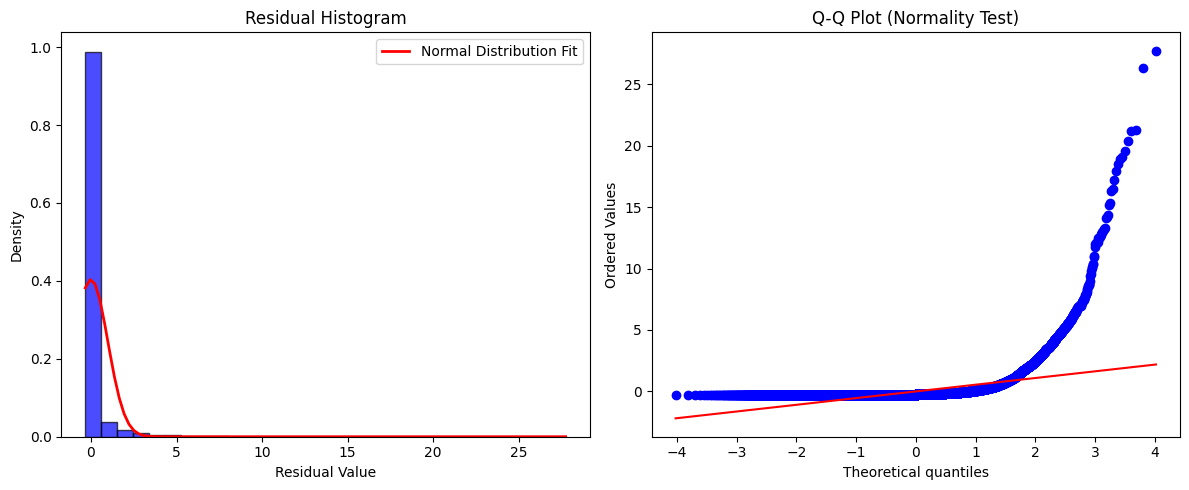

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot

ana = dataset['train_input'].clone()

model_output = model(dataset['train_input'])
print('kan  MSE:', torch.mean((model_output - dataset['train_label'])))

# 将 torch 张量转换为 numpy 数组
residuals_np = model_output.detach().cpu().numpy()  # 确保在 CPU 上并移除梯度

# 检查残差是否为空或维度不对
if residuals_np.size == 0:
    raise ValueError("残差数组为空，请检查输入数据！")
if residuals_np.ndim > 1:
    residuals_np = residuals_np.flatten()  # 如果是多维，展平为一维

# 1. 正态性检验 (Shapiro-Wilk 检验)
stat, p_value = shapiro(residuals_np)
print(f"Shapiro-Wilk 检验: 统计量 = {stat:.4f}, p 值 = {p_value:.4f}")
if p_value > 0.05:
    print("残差可能服从正态分布 (p > 0.05)")
else:
    print("残差可能不服从正态分布 (p <= 0.05)")

# 2. 绘制残差的直方图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals_np, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Residual Histogram')  # 翻译为 "残差直方图"
plt.xlabel('Residual Value')     # 已为英文，无需翻译
plt.ylabel('Density')            # 已为英文，无需翻译

# 添加正态分布曲线作为参考
from scipy.stats import norm
mu, sigma = np.mean(residuals_np), np.std(residuals_np)
x = np.linspace(min(residuals_np), max(residuals_np), 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Distribution Fit')
plt.legend()

# 3. 绘制 Q-Q 图
plt.subplot(1, 2, 2)
probplot(residuals_np, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Test)')  # 翻译为 "Q-Q 图 (正态性检验)"

# 显示图形
plt.tight_layout()
plt.show()

原始 KAN 误差: tensor(4.9787e-06, device='cuda:0', grad_fn=<MeanBackward0>)
特征 0 的 t 检验 p 值: 0.0000
--> 特征 0 统计显著 (p < 0.05)
特征 1 的 t 检验 p 值: 0.0000
--> 特征 1 统计显著 (p < 0.05)
特征 2 的 t 检验 p 值: 0.0000
--> 特征 2 统计显著 (p < 0.05)
特征 3 的 t 检验 p 值: 0.0000
--> 特征 3 统计显著 (p < 0.05)
特征 4 的 t 检验 p 值: 0.0000
--> 特征 4 统计显著 (p < 0.05)
特征 5 的 t 检验 p 值: 0.0000
--> 特征 5 统计显著 (p < 0.05)
特征 6 的 t 检验 p 值: 0.0000
--> 特征 6 统计显著 (p < 0.05)
特征 7 的 t 检验 p 值: 0.0000
--> 特征 7 统计显著 (p < 0.05)
特征 8 的 t 检验 p 值: 0.0000
--> 特征 8 统计显著 (p < 0.05)
特征 9 的 t 检验 p 值: 0.5909
特征 10 的 t 检验 p 值: 0.7767
特征 11 的 t 检验 p 值: 0.0003
--> 特征 11 统计显著 (p < 0.05)
特征 12 的 t 检验 p 值: 0.0000
--> 特征 12 统计显著 (p < 0.05)
特征 13 的 t 检验 p 值: 0.3646

统计显著的特征索引: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12]


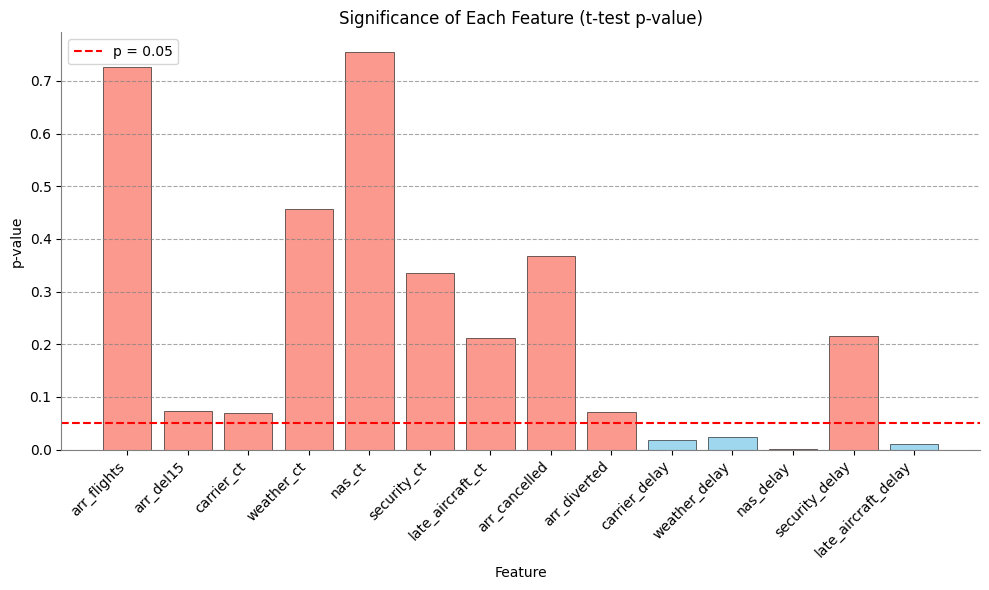

In [17]:
import torch
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# 原始模型输出（未固定任何特征）
ana = dataset['train_input'].clone()
model_output_base = model(ana)
error_base = model_output_base - dataset['train_label']
print('原始 KAN 误差:', torch.mean(error_base))

# 将误差转换为 numpy 数组，用于统计检验
error_base_np = error_base.detach().cpu().numpy().flatten()

# 保存每个特征固定后的误差
errors = []

# 遍历 14 个特征（0 到 13）
for i in range(14):
    ana = dataset['train_input'].clone()
    ana[:, i] = ana[:, i].mean()  # 将第 i 列固定为均值
    model_output = model(ana)
    error = model_output - dataset['train_label']
    
    # 保存误差分布
    error_np = error.detach().cpu().numpy().flatten()
    errors.append(error_np)

# 显著性检验
p_values = []
for i, error_i in enumerate(errors):
    t_stat, p_value = ttest_rel(error_base_np, error_i)
    p_values.append(p_value)
    print(f'特征 {i} 的 t 检验 p 值: {p_value:.4f}')
    if p_value < 0.05:
        print(f'--> 特征 {i} 统计显著 (p < 0.05)')

# 汇总显著特征
significant_features = [i for i, p in enumerate(p_values) if p < 0.05]
print('\n统计显著的特征索引:', significant_features)

# 定义特征名称
feature_names = [
    'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
    'late_aircraft_delay'
]

# 创建图表
plt.figure(figsize=(10, 6))
# 柱状图
bars = plt.bar(range(14), p_values, color='skyblue', edgecolor='black', linewidth=0.5, alpha=0.8)
for i in significant_features:
    bars[i].set_color('salmon')
    bars[i].set_edgecolor('black')
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='p = 0.05')
plt.xlabel('Feature')
plt.ylabel('p-value')
plt.title('Significance of Each Feature (t-test p-value)')
plt.xticks(range(14), feature_names, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')
plt.legend(loc='upper left')

# 设置白色背景
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [13]:
ex_round(model, 3)

ana = dataset['train_input'].clone()

model_output = model(dataset['train_input'])
print('kan  MSE:', torch.mean(model_output - dataset['train_label']))

# 将列表转换为tensor以便计算
# mse_tensor = torch.stack(model_output)

# 计算均值和方差
# mean_mse = torch.mean(model_output)
var_mse = torch.var(model_output)

# print('\n统计结果:')
# print(f'所有MSE的均值: {mean_mse}')
print(f'所有MSE的方差: {var_mse}')


for i in range(21):  # 从0到21，共22列
    ana = dataset['train_input'].clone()
    ana[:, i] = ana[:, i].mean()
    model_output = model(ana)
    print(f'kan {i} MSE:', torch.mean(model_output - dataset['train_label']))
    
    # 将列表转换为tensor以便计算
    # mse_tensor = torch.stack(model_output)
    
    # 计算均值和方差
    # mean_mse = torch.mean(model_output)
    var_mse = torch.var(model_output)
    
    # print('\n统计结果:')
    # print(f'所有MSE的均值: {mean_mse}')
    print(f'所有MSE的方差: {var_mse}')
    
    # ana[:, i] = 1
    # model_output = model(ana)
    # print(f'kan {i} MSE:', torch.mean((model_output - dataset['train_label'])**2))
# print('TKEB MSE:', torch.mean((torch.from_numpy(np_label_1.astype(np.float32)).cpu()[:200] - torch.abs(dataset['train_label']))**2))
#print(torch.abs(model_output))

kan  MSE: tensor(-2.6742e-09, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.0099234580993652
kan 0 MSE: tensor(-0.0205, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.1610592603683472
kan 1 MSE: tensor(-0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.164474368095398
kan 2 MSE: tensor(-0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.1210561990737915
kan 3 MSE: tensor(-0.0300, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.15178382396698
kan 4 MSE: tensor(-0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.1383987665176392
kan 5 MSE: tensor(-0.0204, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.130481243133545
kan 6 MSE: tensor(-0.0309, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.1626744270324707
kan 7 MSE: tensor(-0.0115, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.0943586826324463
kan 8 MSE: tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
所有MSE的方差: 1.1193283796310425
kan 9 MSE: tensor(-0.0

[5.2162046 3.5954905 3.339788  2.9111485 4.1660066 3.7711768 5.0723557
 3.6002848 3.3013387 5.1032696 2.52881   6.143367  4.851316  3.381338
 3.6655989 3.8582196 4.3261423 2.6532655 4.385847  4.7868114 0.       ]


Text(0, 0.5, 'feature attribution score')

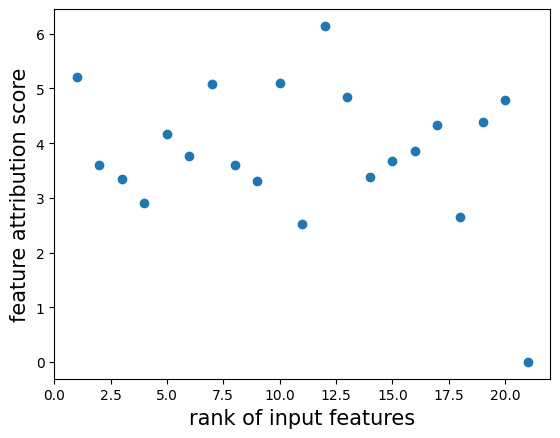

In [15]:
print(model.feature_score.cpu().detach().numpy())
import matplotlib.pyplot as plt
plt.scatter(np.arange(21)+1, model.feature_score.cpu().detach().numpy())
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [146]:
model_output = model(dataset['train_input'])
print(model_output)

tensor([[ 0.0010],
        [-0.0018],
        [ 0.0097],
        [ 0.0005],
        [-0.0071],
        [ 0.0014],
        [-0.0167],
        [-0.0006],
        [ 0.0202],
        [ 0.0119],
        [ 0.0043],
        [ 0.0081],
        [ 0.0189],
        [ 0.0216],
        [ 0.0187],
        [ 0.0080],
        [ 0.0143],
        [-0.0025],
        [ 0.0230],
        [ 0.0166],
        [ 0.0070],
        [-0.0019],
        [ 0.0109],
        [ 0.0096],
        [ 0.0200],
        [ 0.0046],
        [ 0.0011],
        [ 0.0265],
        [ 0.0086],
        [ 0.0133],
        [ 0.0186],
        [ 0.0006],
        [ 0.0368],
        [ 0.0049],
        [-0.0046],
        [ 0.0361],
        [ 0.0106],
        [ 0.0261],
        [ 0.0047],
        [ 0.0112],
        [ 0.0319],
        [ 0.0485],
        [ 0.0159],
        [ 0.0093],
        [ 0.0257],
        [ 0.0169],
        [ 0.0148],
        [ 0.0163],
        [ 0.0413],
        [ 0.0234],
        [ 0.0097],
        [ 0.0179],
        [ 0.

In [57]:
grids = [5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(datasemodel = model.refine(10)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 1.31e+10 | test_loss: 1.44e+10 | reg: 5.44e+06 | : 100%|█| 50/50 [00:01<00:00, 47.79it


saving model version 0.4
saving model version 0.5


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 42.57it/s]


saving model version 0.6
saving model version 0.7


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 35.41it/s]


saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:02<00:00, 21.24it/s]


saving model version 0.10
